In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/sugammadex/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

In [29]:
ts_neo = df[df["MED"] == "neostigmine"].loc["2017-04-01":].resample("MS").count()[["MED"]]
ts_sug = df[df["MED"] == "sugammadex"].loc["2017-04-01":].resample("MS").count()[["MED"]]

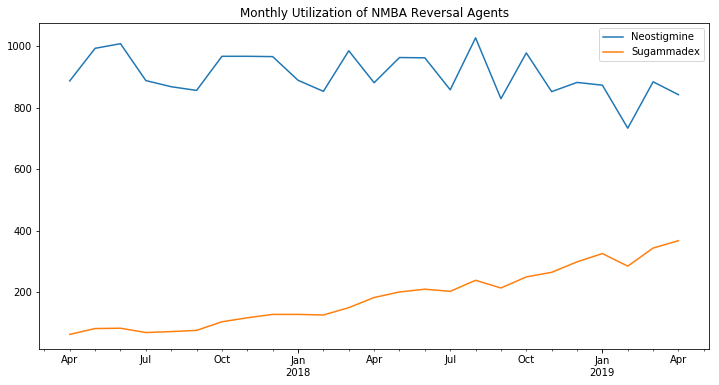

In [31]:
ts_month = pd.DataFrame()
ts_month["Neostigmine"] = ts_neo["MED"]
ts_month["Sugammadex"] = ts_sug["MED"]
#ts_month = ts_month.astype('float64')
ax = ts_month.plot(legend=True, figsize=(12, 6), title="Monthly Utilization of NMBA Reversal Agents")
ax.set(xlabel="");

In [32]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [33]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## Sugammadex Model

Check for seasonality

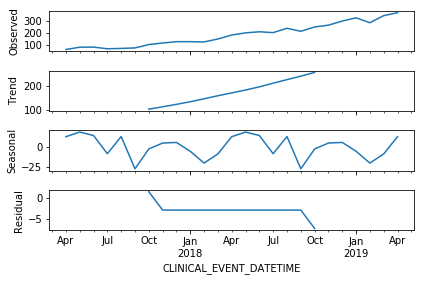

In [34]:
seasonal_decompose(ts_month["Sugammadex"], model="add").plot();

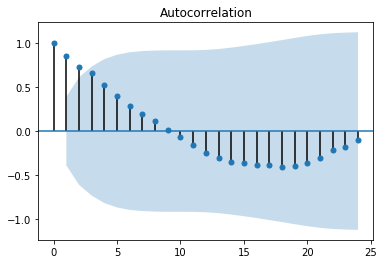

In [35]:
plot_acf(ts_month["Sugammadex"]);

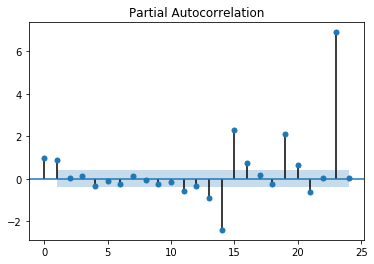

In [36]:
plot_pacf(ts_month["Sugammadex"]);

In [37]:
adf_test(ts_month["Sugammadex"])

Augmented Dickey-Fuller Test: 
ADF test statistic       1.392371
p-value                  0.997079
# lags used              9.000000
# observations          15.000000
critical value (1%)     -3.964443
critical value (5%)     -3.084908
critical value (10%)    -2.681814
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
#ts_diff = ts_month.diff().diff().diff().diff().diff().diff()
#ts_diff.dropna(inplace=True)
#ts_diff = diff(ts_month["Sugammadex"], k_diff=12)
#adf_test(ts_diff)

In [39]:
auto_arima(ts_month["Sugammadex"], seasonal=False).summary()

LinAlgError: Array must not contain infs or NaNs

In [180]:
n = 12
#train = ts_month.iloc[:len(ts_month)-n]
#test = ts_month.iloc[len(ts_month)-n:]
train = ts_sug.iloc[:len(ts_sug)-n]
test = ts_sug.iloc[len(ts_sug)-n:]

In [181]:
test

,MED
CLINICAL_EVENT_DATETIME,
2018-05-01,200
2018-06-01,209
2018-07-01,202
2018-08-01,238
2018-09-01,213
2018-10-01,249
2018-11-01,264
2018-12-01,298
2019-01-01,325


In [64]:
model = ARIMA(train, order=(0, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.MED   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -47.209
Method:                       css-mle   S.D. of innovations             12.272
Date:                Thu, 02 May 2019   AIC                            100.418
Time:                        12:27:11   BIC                            101.873
Sample:                    05-01-2017   HQIC                            99.880
                         - 04-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.8120      4.897      2.208      0.052       1.213      20.411
ma.L1.D.MED     0.4142      0.242      1.708      0.118      -0.061       0.889
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.4142           +0.0000j            2.4142            0.5000
-----------------------------------------------------------------------------
"""

In [65]:
start = len(train)
end = len(ts_sug)-1
preds_arima = results.predict(start, end, dynamic=False, typ="levels").rename("ARIMA")

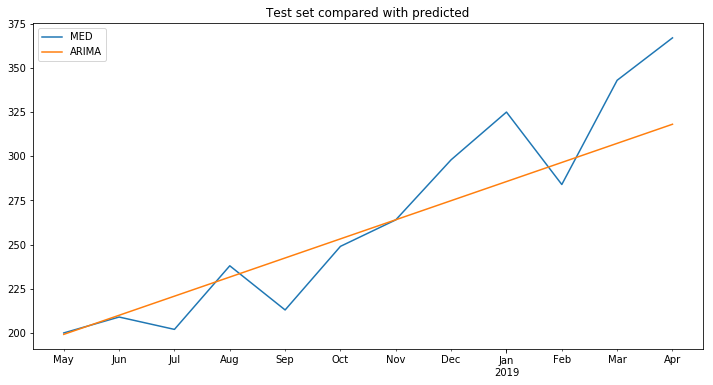

In [68]:
ax = test.plot(legend=True, figsize=(12, 6), title="Test set compared with predicted")
preds_arima.plot(legend=True)
ax.set(xlabel="");

In [191]:
mse_arima = mean_squared_error(test["MED"], preds_arima)
rmse_arima = rmse(test["MED"], preds_arima)

print(f'MSE ARIMA: {mse_arima:11.10}')
print(f'RMSE ARIMA: {rmse_arima:11.10}')

MSE ARIMA: 598.5079078
RMSE ARIMA: 24.46442126


In [171]:
n_forecast = 12
model = ARIMA(ts_sug, order=(0, 1, 1))
results = model.fit()
fcast = results.predict(start=len(ts_sug), end=len(ts_sug)+(n_forecast-1), typ="levels").rename("ARIMA Forecast")

In [172]:
fcast

2019-05-01    367.334437
2019-06-01    379.666160
2019-07-01    391.997883
2019-08-01    404.329607
2019-09-01    416.661330
2019-10-01    428.993054
2019-11-01    441.324777
2019-12-01    453.656500
2020-01-01    465.988224
2020-02-01    478.319947
2020-03-01    490.651671
2020-04-01    502.983394
Freq: MS, Name: ARIMA Forecast, dtype: float64

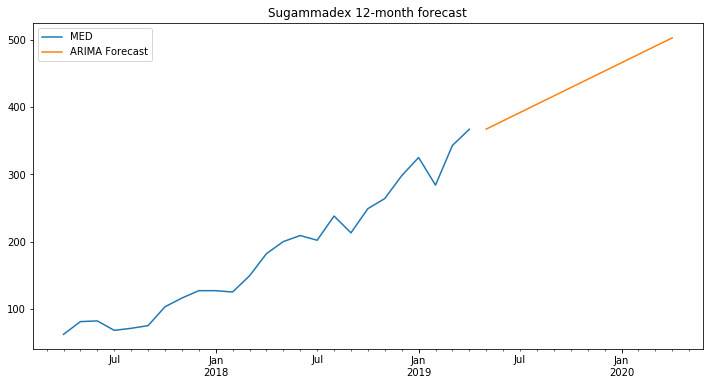

In [173]:
ax = ts_sug.plot(legend=True, figsize=(12, 6), title="Sugammadex 12-month forecast")
fcast.plot(legend=True)
ax.set(xlabel="");

## RNN

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [240]:
n_input = 9
train = ts_sug.iloc[:len(ts_sug)-n_input]
test = ts_sug.iloc[len(ts_sug)-n_input:]

In [241]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [277]:
model = Sequential()
#model.add(LSTM(150, input_shape=(n_input, 1)))
model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
model.add(LSTM(300, activation="relu", input_shape=(n_input, 1), return_sequences=True))
model.add(LSTM(150, activation="relu", input_shape=(n_input, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 9, 300)            362400    
_________________________________________________________________
lstm_30 (LSTM)               (None, 9, 300)            721200    
_________________________________________________________________
lstm_31 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________


In [278]:
model.fit_generator(generator, epochs=100)

Epoch 1/100
7/7 [==============================] - 20s 3s/step - loss: 0.5222
Epoch 2/100
7/7 [==============================] - 2s 218ms/step - loss: 0.1594
Epoch 3/100
7/7 [==============================] - 2s 223ms/step - loss: 0.0470
Epoch 4/100
7/7 [==============================] - 2s 235ms/step - loss: 0.0438
Epoch 5/100
7/7 [==============================] - 2s 244ms/step - loss: 0.0242
Epoch 6/100
7/7 [==============================] - 2s 226ms/step - loss: 0.0206
Epoch 7/100
7/7 [==============================] - 2s 261ms/step - loss: 0.0231
Epoch 8/100
7/7 [==============================] - 2s 229ms/step - loss: 0.0276
Epoch 9/100
7/7 [==============================] - 2s 224ms/step - loss: 0.0118
Epoch 10/100
7/7 [==============================] - 2s 232ms/step - loss: 0.0210
Epoch 11/100
7/7 [==============================] - 2s 228ms/step - loss: 0.0322
Epoch 12/100
7/7 [==============================] - 2s 225ms/step - loss: 0.0133
Epoch 13/100
7/7 [=====================

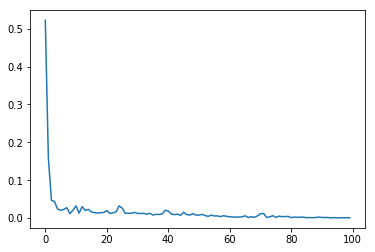

In [279]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [280]:
test_preds = []
first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, 1))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [281]:
true_preds = scaler.inverse_transform(test_preds)
test["Predictions"] = true_preds

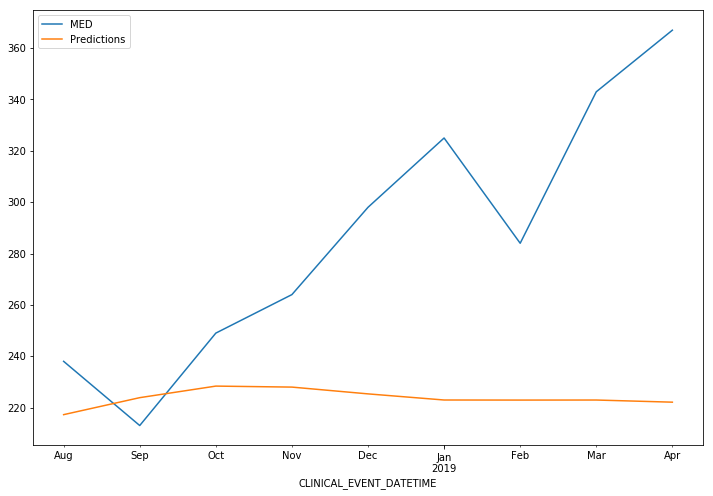

In [282]:
test.plot(figsize=(12, 8));

In [283]:
mse_rnn = mean_squared_error(test["MED"], test["Predictions"])
rmse_rnn = rmse(test["MED"],  test["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 6346.129015
RMSE RNN: 79.66259483


## Neostigmine

In [33]:
from statsmodels.tsa.ar_model import AR,ARResults

In [52]:
model = AR(train["Neostigmine"])
ar_fit = model.fit()
print(f'Lag: {ar_fit.k_ar}')

Lag: 8


In [53]:
ar_pred = ar_fit.predict(start, end).rename("AR Predications")

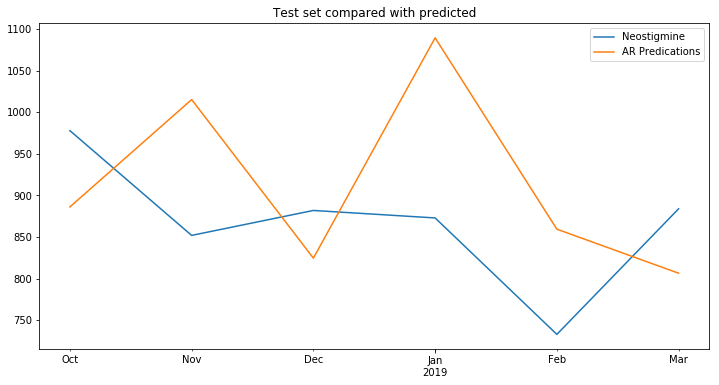

In [55]:
ax = test["Neostigmine"].plot(legend=True, figsize=(12, 6), title="Test set compared with predicted")
ar_pred.plot(legend=True)
ax.set(xlabel="");

In [57]:
ar_fit.aic

7.897380946559555

In [76]:
model = AR(ts_month["Neostigmine"])
ar_fit = model.fit(maxlag=4)
start = len(ts_month)
end = len(ts_month)-1
ar_fcast = ar_fit.predict(start, end+11).rename("AR Forecast")

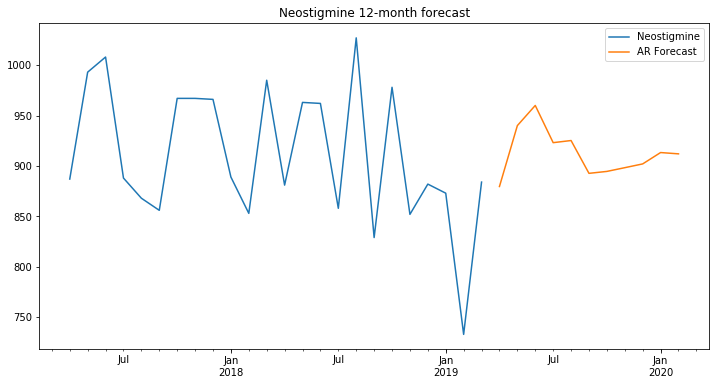

In [77]:
ax = ts_month["Neostigmine"].plot(legend=True, figsize=(12, 6), title="Neostigmine 12-month forecast")
ar_fcast.plot(legend=True)
ax.set(xlabel="");